In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os, subprocess
from itertools import combinations
import scipy
from sklearn.metrics import mean_squared_error

2024-03-13 15:04:39.974339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sequences = pd.read_csv('../data/enformer_sequences.bed', header=None, sep='\t')
bin_index = [447, 448]
model_name = 'enformer'
seq_length = 196608
outdir = utils.make_dir('../results/train_test_valid/')

In [3]:
# Trivial but horrible
for fold in sequences[3].unique():

    cmd = f'less ../data/enformer_sequences.bed | grep {fold}  > tmp.bed;'
    cmd += f'bedtools sort -i tmp.bed > tmp_s.bed;'
    cmd += f'bedtools merge -i tmp_s.bed > {outdir}/enformer_{fold}_sequences_merged.bed; rm tmp.bed tmp_s.bed'
    
    results = subprocess.run(
        cmd, shell=True)


In [4]:
context_test_results = pd.read_csv('../results/summary_csvs/enformer/context_dependence_test.csv')

In [7]:
sequences_with_tss = []

for path in glob.glob('../results/gencode_tss_predictions/enformer/*npy'):
    ### expand selected TSS sequences to enformer sequence length and save into => ../results/{cell}_tss_selected.bed
    file_prefix = path.split('/')[-1].split('.')[0]
    chrom_i, tss_i = file_prefix.split('_')[1:3]
    start_i, end_i = int(tss_i) - seq_length//2, int(tss_i) + seq_length//2
    if start_i >= 0:
        sequences_with_tss.append([chrom_i, start_i, end_i])
print(len(sequences_with_tss))
pd.DataFrame(sequences_with_tss).to_csv('tmp.bed', sep='\t', header=None, index=None)
    
cmd = f'bedtools sort -i tmp.bed > {outdir}/all_tss_selected.bed; rm tmp.bed'
subprocess.run(cmd, shell=True)

fold_seq_dfs = []
for fold in sequences[3].unique():
    fold_seqs = []
    fold_bed = f'{outdir}/{fold}.bed'
    cmd = f'bedtools intersect -a {outdir}/all_tss_selected.bed -b {outdir}/enformer_{fold}_sequences_merged.bed  -wa -f 1.0 > {fold_bed}'

    subprocess.run(
        cmd, shell=True)




    

51990


In [8]:
nec_result_summary = pd.read_csv('../results/summary_csvs/enformer/necessity_test.csv')
nec_result_summary['seq_start'] = [int(r.split('_')[2])-196608//2 for r in nec_result_summary['seq_id']]
nec_result_summary['chrom'] = [r.split('_')[1] for r in nec_result_summary['seq_id']]

In [9]:
fold = 'train'
fold_set = pd.read_csv(f'{outdir}/{fold}.bed', sep='\t', header=None)


In [10]:
fold_set.columns = ['chrom', 'seq_start', 'seq_end']

In [11]:
merged = nec_result_summary.merge(fold_set, on=['chrom', 'seq_start'])

In [12]:
merged['cell_line'].unique()

array(['PC-3', 'K562', 'GM12878'], dtype=object)

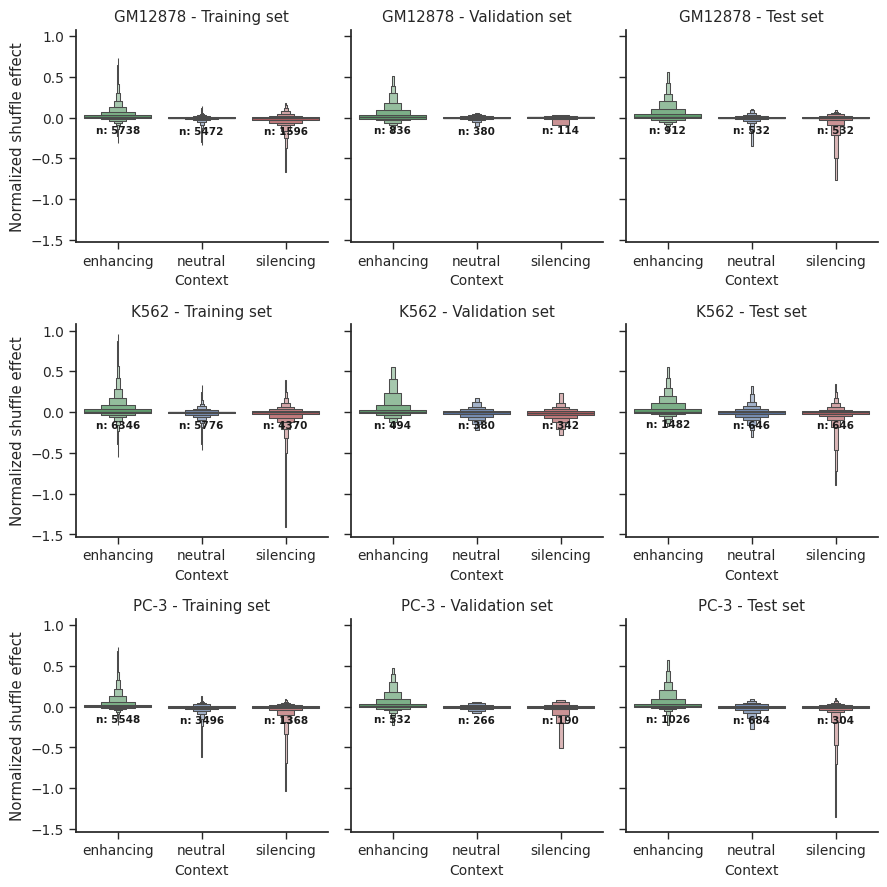

In [28]:
titles = {'train': 'Training set', 'valid': 'Validation set', 'test': 'Test set'}
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


fig, axes = plt.subplots(3, 3, figsize=[9, 9], sharey=True)


for f, fold in enumerate(['train', 'valid', 'test']):

    fold_set = pd.read_csv(f'{outdir}/{fold}.bed', sep='\t', header=None)
    fold_set.columns = ['chrom', 'seq_start', 'seq_end']
    merged = nec_result_summary.merge(fold_set, on=['chrom', 'seq_start'])
    
    for j, (cell, df) in enumerate(merged.groupby('cell_line')):
        df = df.sort_values('context')
        ax = axes[j, f]
        sns.boxenplot(x='context', y='Normalized shuffle effect', data=df, 
                      showfliers=False,
                      hue='context', ax=ax,
                      palette = my_pal)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
        # ax.legend(bbox_to_anchor=[1.6, 1])
    
        # add number of observations in each box
        medians = df.groupby(['context'])['Normalized shuffle effect'].median().values
        nobs = df['context'].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]
    
        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax.get_xticklabels()):
            ax.text(pos[tick],
                    medians[tick] - .2,
                    nobs[tick],
                    horizontalalignment='center',
                    size='x-small',
                    color='k',
                    weight='semibold')
        ax.set_title(f"{cell} - {titles[fold]}")
        # ax.get_legend().remove()
    plt.tight_layout()
    
    

fig.savefig(f'pdfs/necessity_and_sufficiency/enformer_necessity_test_train_test_val_split.png')
    